## Data engineering and preparation

In [26]:
import pandas as pd 

df_seed_labels = pd.read_csv('./Data/seed_labels.csv')
df_seed_labels['prediction'].value_counts()

prediction
0    8317
1     302
Name: count, dtype: int64

In [27]:
# Prepare transaction data
df_transcation_native = pd.read_parquet('./Data/transaction_native_seeder.parquet')
df_transcation_token = pd.read_parquet('./Data/transaction_token_seeder.parquet')

df_transcation_native_clean = df_transcation_native[df_transcation_native['FROM_ADDRESS'].notna() & df_transcation_native['TO_ADDRESS'].notna()]
df_transcation_token_clean = df_transcation_token[df_transcation_token['FROM_ADDRESS'].notna() & df_transcation_token['TO_ADDRESS'].notna()]

df_transcation_native_clean = pd.merge(df_seed_labels, df_transcation_native_clean, left_on='eoa', right_on='FROM_ADDRESS', how='inner')
df_transcation_native_clean = pd.merge(df_seed_labels, df_transcation_native_clean, left_on='eoa', right_on='TO_ADDRESS', how='inner')
df_transcation_token_clean = pd.merge(df_seed_labels, df_transcation_token_clean, left_on='eoa', right_on='FROM_ADDRESS', how='inner')
df_transcation_token_clean = pd.merge(df_seed_labels, df_transcation_token_clean, left_on='eoa', right_on='TO_ADDRESS', how='inner')

df_transcation_native_clean = df_transcation_native_clean[df_transcation_native_clean['FROM_ADDRESS'].notna() & df_transcation_native_clean['TO_ADDRESS'].notna()]
df_transcation_token_clean = df_transcation_token_clean[df_transcation_token_clean['TO_ADDRESS'].notna() & df_transcation_token_clean['TO_ADDRESS'].notna()]


In [28]:
import networkx as nx

G = nx.MultiDiGraph()

for _, row in df_transcation_native_clean.iterrows():
    G.add_edge(row['FROM_ADDRESS'], row['TO_ADDRESS'], weight = row['AMOUNT_USD'])

for _, row in df_transcation_token_clean.iterrows():
    G.add_edge(row['FROM_ADDRESS'], row['TO_ADDRESS'], weight = row['AMOUNT_USD'])

In [29]:
from torch_geometric.utils import from_networkx
import numpy as np
import torch

G_int = nx.convert_node_labels_to_integers(G)

data = from_networkx(G_int)
data.x = torch.tensor([np.random.rand(128) for i in G_int.nodes()], dtype=torch.float)
data.edge_attr = torch.tensor([edge[2]['weight'] for edge in G.edges(data=True)], dtype=torch.float)


In [30]:
# Prepare target variables
y_df = df_seed_labels[df_seed_labels['eoa'].isin(list(G.nodes()))]
y_df[y_df['eoa'] == G.nodes()]['prediction'].head()
y_df['eoa'] = pd.Categorical(y_df['eoa'], categories=list(G.nodes()), ordered=True)
y = y_df.sort_values('eoa')['prediction'].values
data.y = torch.tensor(y, dtype=torch.float)
y

/tmp/ipykernel_129199/990522802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_df['eoa'] = pd.Categorical(y_df['eoa'], categories=list(G.nodes()), ordered=True)


array([0, 0, 1, ..., 0, 0, 1])

## Model creation and training

In [37]:
from models import NodeClassifier

cex_model = NodeClassifier(in_channels=128, hidden_channels=32, out_channels=1)
optimizer = torch.optim.Adam(cex_model.parameters(), lr=1e-3, weight_decay=5e-4)
loss_fn = torch.nn.BCELoss()
loss_values = []
torch.nn.utils.clip_grad_norm_(cex_model.parameters(), max_norm=1.0)

epochs = 200

data.edge_attr = torch.nan_to_num(data.edge_attr, nan=0.0)

for epoch in range(epochs):
    cex_model.train()
    optimizer.zero_grad()
    out = cex_model(data.x, data.edge_index, data.edge_attr)
    if torch.isnan(data.edge_attr).any():
        print("NaN detected in output!")
        break
    loss = loss_fn(out.squeeze(), data.y)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(cex_model.parameters(), max_norm=1.0)
    optimizer.step()
    loss_values.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.9602
Epoch 100, Loss: 0.0634


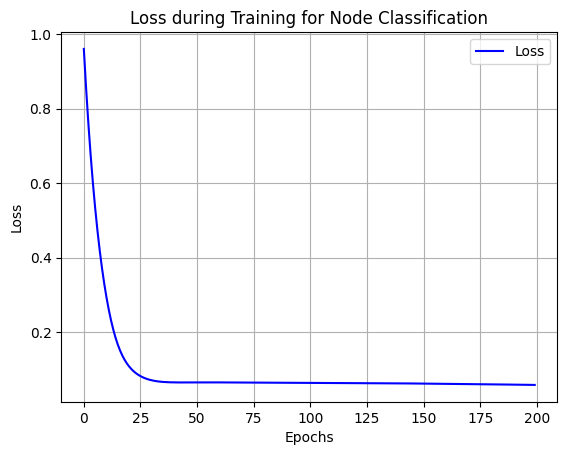

In [38]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), loss_values, linestyle='-', color='b', label='Loss')
plt.title('Loss during Training for Node Classification')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
cex_model.eval()
_, pred = cex_model(data.x, data.edge_index, data.edge_attr).max(dim=1)

# Accuracy on test nodes
correct = (pred == data.y).sum()
acc = int(correct) / int(data['num_nodes'])
print(f"Overall Accuracy after training : {acc:.4f}")

Overall Accuracy after training : 0.9899


In [40]:
1 in pred

False

### Discussion 
-A simple model was created : attention layer + convolution layer

-The features for the nodes and the transactions need to be enriched

-Data splitting needs to be done and more careful data preparation needs to be put into place

-Add grid search to look for the best parameters of the model

-Cross-validation can be helpful to better evaluation the model

-Using an improved model, better results can be obtained